In [1]:
# necessary libraries for pre-processing
import utils
import pandas as pd
import numpy as np
import math
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing

In [2]:
pd.set_option('display.max_columns', 200)
# pd.set_option('display.width', 1000)

## Statistical Analysis

In [3]:
def get_col_max(df, col):
    '''Get the maximum value of a given column'''
    return df[col].max()

def get_col_min(df, col):
    '''Get the minimum value of a given column'''
    return df[col].min()

def get_col_count(df, col):
    '''Get the number of elements of a given column'''
    return df[col].count()

def get_col_avg(df, col):
    '''Get the average value of a given column'''
    return df[col].mean()

def get_col_std(df, col):
    '''Get the standar deviation value of a given column'''
    return df[col].std()

def get_first(df):
    '''Get the first entry of a dataframe'''
    return df.iloc[0]

# Useful functions for preprocessing

In [4]:
def convert_date(df, column, date_format='%y%m%d'):
    '''Convert the given column containg dates in the given format
    to the standard date format and type'''
    copy_df = df.copy()
    copy_df[column] = pd.to_datetime(copy_df[column], format=date_format)

    return copy_df

In [5]:
def encode_column(df, column):
    '''Encode the given column of the given dataframe.'''
    copy_df = df.copy()

    le = preprocessing.LabelEncoder()
    le.fit(df[column].unique())
    copy_df[column] = le.transform(copy_df[column])
    
    return copy_df

In [6]:
def normalize_columns(df, columns):
    '''Normalize the given columns for range between [0, 1]'''
    for col in columns:
        col_min = get_col_min(df, col)
        col_max = get_col_max(df, col)
        
        df[col] = (df[col] - col_min)/\
                    (col_max - col_min)

In [7]:
def get_df_correlation(df, size=(11, 9)):
    '''Get the correlation between the dataframe features'''
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    plt.subplots(figsize=size)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                     square=True, linewidths=.1, cbar_kws={"shrink": .5})
    
    y_lim = ax.get_ylim();
    ax.set_ylim(np.ceil(y_lim[0]), np.floor(y_lim[1]))

    plt.show()

In [8]:
def column_density_plot(df, col):
    '''Get a density plot for the given column in the given dataframe.
    Useful for outlier detection'''
    sns.kdeplot(df[col], shade=True)
    plt.show()

In [9]:
def scatterplot_two_cols(df, col1, col2):
    '''Get a scatterplot for the given two columns'''
    # Set up the matplotlib figure
    plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.scatterplot(data=df, x=col1, y=col2,
                    hue='status',palette=cmap, sizes=(47,47))
    plt.show()

In [10]:
def get_features_histogram(df, figsize_val = (12, 9)):
    '''Get a histogram relating the features of the given dataframe'''
    fig, axes = plt.subplots(
        math.ceil(len(df.columns) / 3),
        3, figsize=figsize_val)
    loan = df[df.status==1]
    do_not_loan = df[df.status==-1]

    ax = axes.ravel() # flat axes with numpy ravel

    for i in range(len(df.columns)):
      _, bins = np.histogram(df.iloc[:,i], bins=40)
      ax[i].hist(do_not_loan.iloc[:,i], bins=bins, color='r', alpha=.5) #red color for do_not_loan class
      ax[i].hist(loan.iloc[:,i], bins=bins, color='g', alpha=0.3) #blue color for loan class
      ax[i].set_title(df.columns[i], fontsize=9)
      ax[i].axes.get_xaxis().set_visible(False)
      ax[i].set_yticks(())

    ax[0].legend(['loan','do not loan'], loc='best', fontsize=8)
    plt.tight_layout()
    plt.show()

## Imputation

In [11]:
def get_null_summary(dataset):
    '''Get a null summary display'''
    display(dataset.isnull().mean())

In [12]:
def clean_nulls(dataset, threshold=0.7):
    '''Clean nulls from the given table.
    If the nulls in a column are higher than the given threshold the entire column is deleted.
    If the nulls in a row are higher than the row, the row is also deleted.
    The threshold is a value between 0 and 1'''
    #Dropping columns with missing value rate higher than threshold
    dataset = dataset[dataset.columns[dataset.isnull().mean() < threshold]]

    #Dropping rows with missing value rate higher than threshold
    dataset = dataset.loc[dataset.isnull().mean(axis=1) < threshold]
    
    return dataset

In [13]:
def numerical_imputation(dataset, replacer=None):
    '''When null values exist, set them using the median of the colum,
    or a replacer, if one was given'''
    dataset = dataset.fillna(replacer if replacer is not None else dataset.median())

    return dataset

In [14]:
def categorical_imputation(dataset, column_name, replacer=None):
    '''Replace the inexistent values of the given column with the given replacer.
    If None replacer was ginve, use the column maximum value'''
    #Max fill function for categorical columns
    dataset[column_name].fillna(replacer if replacer is not None else \
                                dataset[column_name].value_counts()
                                                    .idxmax(),
                                inplace=True)
    
    return dataset

## Handling Outliers

In [15]:
def display_to_drop_std(dataset, column, mult_factor=3):
    '''Display the rows that will be dropped using the std approach'''
    upper_lim = dataset[column].mean() + dataset[column].std() * mult_factor
    lower_lim = dataset[column].mean() - dataset[column].std() * mult_factor

    display(dataset[(dataset[column] >= upper_lim) & (dataset[column] <= lower_lim)])

def drop_outliers_std(dataset, column, mult_factor=3):
    '''Drop the outlier rows with standard deviation'''
    upper_lim = dataset[column].mean() + dataset[column].std() * mult_factor
    lower_lim = dataset[column].mean() - dataset[column].std() * mult_factor

    return dataset[(dataset[column] < upper_lim) & (dataset[column] > lower_lim)]

In [16]:
def display_to_drop_percentile(dataset, column):
    '''Display the rows that will be dropped with Percentiles approach'''
    upper_lim = dataset[column].quantile(.95)
    lower_lim = dataset[column].quantile(.05)

    display(dataset[(dataset[column] >= upper_lim) & (dataset[column] <= lower_lim)])

def drop_outliers_percentile(dataset, column):
    '''Drop the outlier rows with Percentiles approach'''
    upper_lim = dataset[column].quantile(.95)
    lower_lim = dataset[column].quantile(.05)

    data = dataset[(dataset[column] < upper_lim) & (dataset[column] > lower_lim)]

## Binning

In [17]:
def numerical_binning(dataset):
    # TODO
    # https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114
    return False

In [18]:
def categorical_binning(dataset):
    # TODO
    return False

# Feature Engineering

### For a first simpler approach, we will only use the 'loan' table

In [19]:
# Loading the tables both used for train and test
account_df = utils.read_csv_to_df('competition_dataset/account.csv', delimiter=';')
disp_df = utils.read_csv_to_df('competition_dataset/disp.csv', delimiter=';')
client_df = utils.read_csv_to_df('competition_dataset/client.csv', delimiter=';')
demogra_df = utils.read_csv_to_df('competition_dataset/district.csv', delimiter=';')

# Loading the train tables
loan_df = utils.read_csv_to_df('competition_dataset/loan_train.csv', delimiter=';')
card_df = utils.read_csv_to_df('competition_dataset/card_train.csv', delimiter=';')
trans_df = utils.read_csv_to_df('competition_dataset/trans_train.csv', delimiter=';')

# Loading the test tables
loan_test_df = utils.read_csv_to_df('competition_dataset/loan_test.csv', delimiter=';')
card_test_df = pd.concat([utils.read_csv_to_df('competition_dataset/card_test.csv', delimiter=';'),
                          card_df])
trans_test_df = pd.concat([utils.read_csv_to_df('competition_dataset/trans_test.csv', delimiter=';'),
                            trans_df])

print(' ::: Tables Scheme :::')
print('\n\n\t LOAN TABLE')
display(loan_df.head())
print('\n\n\t ACCOUNT TABLE')
display(account_df.head())
print('\n\n\t DISPOSITION TABLE')
display(disp_df.head())
print('\n\n\t CREDIT CARD TABLE')
display(card_df.head())
print('\n\n\t CLIENT TABLE')
display(client_df.head())
print('\n\n\tTRANSACTIONS TABLE')
display(trans_df.head())
print('\n\n\tDEMOGRAPHIC TABLE')
display(demogra_df.head())

 ::: Tables Scheme :::


	 LOAN TABLE


/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1




	 ACCOUNT TABLE


,account_id,district_id,frequency,date
0,576,55,monthly issuance,930101
1,3818,74,monthly issuance,930101
2,704,55,monthly issuance,930101
3,2378,16,monthly issuance,930101
4,2632,24,monthly issuance,930102




	 DISPOSITION TABLE


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT




	 CREDIT CARD TABLE


,card_id,disp_id,type,issued
0,1005,9285,classic,931107
1,104,588,classic,940119
2,747,4915,classic,940205
3,70,439,classic,940208
4,577,3687,classic,940215




	 CLIENT TABLE


,client_id,birth_number,district_id
0,1,706213,18
1,2,450204,1
2,3,406009,1
3,4,561201,5
4,5,605703,5




	TRANSACTIONS TABLE


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN,NaN,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN,NaN,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN,NaN,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN,NaN,NaN




	DEMOGRAPHIC TABLE


,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


# Individual pre processement of tables

In [20]:
def process_loans(loans_df, debug=False):
    '''Pre process the loan table'''
    if debug:
        print(' > Raw loan table representation')
        display(loans_df)
        print(' > Raw loan table correlations')
        get_df_correlation(loans_df)
        
    processed_df = convert_date(loans_df, 'date')
    
    # As there is a correlation between amount, duration & payments
    if debug:
        print(' > There is naturally a correlation between the amount, duration and payments columns,'+
              'since amount = columns * payments')
        scatterplot_two_cols(processed_df, 'amount', 'duration')
        scatterplot_two_cols(processed_df, 'amount', 'payments')
        print(' > Natural correlations, since the larger the amount the larger the monthly payment or the duration.')
        
    # No User has a history of loanning, at least in the train dataset
    # Since amount = payments * duration we can conclude that there is no interest rate to the bank
        
    return processed_df

In [21]:
def process_account(accounts_df, debug=False):
    '''Pre process the accounts table'''
    if debug:
        print(' > Raw accounts table representation')
        display(accounts_df)
        print(' > Raw accounts table correlations')
        get_df_correlation(accounts_df)
        
    processed_account = convert_date(account_df, 'date')
    
    # Encode categorical column
    df = encode_column(processed_account, 'frequency')
        
    if debug:
        print(' > Lets encode the frequency column:')
        display(df)
        print(' > And the features correlation:')
        get_df_correlation(df)

    return df

In [22]:
def process_dispostition(disp_df, debug=False):
    '''Pre process the dispositions table'''
    if debug:
        print(' > Raw disposition table representation')
        display(disp_df)
        print(' > Raw disposition table correlations')
        get_df_correlation(disp_df)
        
    processed_disp = disp_df.copy()
    
    # Renaming disp attributes
    processed_disp.loc[processed_disp["type"]=="OWNER","type"] = "O"
    processed_disp.loc[processed_disp["type"]=="DISPONENT","type"] = "U"
    
    # Transform numerical into categorical
    df = pd.get_dummies(processed_disp)
    
    if debug:
        print(' > Transformed the categorical type column into numerical respective columns')
        display(df)
        print(' > Since the 2 categories are depedent, we can remove one of them, for removing redundant data')
        get_df_correlation(df)
        
    # Cannot process further as needs merging with other columns
    return df

In [23]:
def process_card(card_df, debug=False):
    '''Pre process the credit card table'''
    if debug:
        print(' > Raw credit card table representation')
        display(card_df)
        print(' > Raw credit card table correlations')
        get_df_correlation(card_df)

    processed_card = convert_date(card_df, 'issued')

    # Renaming card attributes
    processed_card.loc[processed_card["type"]=="classic","type"] = "C"
    processed_card.loc[processed_card["type"]=="gold","type"] = "G"
    processed_card.loc[processed_card["type"]=="junior","type"] = "J"
    
    # Transform numerical into categorical & removing useless column
    df = pd.get_dummies(processed_card)
    df = df.drop(['card_id'], axis=1)
    
    if debug:
        print(' > Transformed the categorical type column into numerical respective columns')
        display(df)
        print(' > Since the 2 categories are depedent, we can remove one of them, for removing redundant data')
        get_df_correlation(df)
        
    # Cannot process further as needs merging with other columns
    return df

In [24]:
def process_client(client_df, debug=False):
    '''Pre process the client table'''
    if debug:
        print(' > Raw client table representation')
        display(client_df)
        print(' > Raw client table correlations')
        get_df_correlation(client_df)
        
    processed_df = client_df.copy()
        
    # Getting year, day, and month+50 if women
    processed_df['year'] = 1900 + (processed_df['birth_number'] // 10000)
    processed_df['month_gender'] = (processed_df['birth_number'] % 10000) // 100
    processed_df['day'] = processed_df['birth_number'] % 100

    # Extracting gender and month
    processed_df['gender'] = np.where(processed_df['month_gender']>=50, 1, 0)
    processed_df['month'] = np.where(processed_df['month_gender']>=50, processed_df['month_gender']-50, processed_df['month_gender'])

    # Composing data
    processed_df['birth_date'] = processed_df['year'] * 10000 +\
                                 processed_df['month'] * 100 +\
                                 processed_df['day']
    df = convert_date(processed_df, 'birth_date', '%Y%m%d')
    
    # Dropping useless columns
    df = df.drop(['birth_number', 'year', 'month_gender', 'month', 'day'], axis=1)
    
    if debug:
        print(' > After extracting the gender from the date we have:')
        display(df)
        print(' > Notice the gender representation:\n\t * 1 if female\n\t * 0 if male')
        get_df_correlation(df)
    
    return df

In [25]:
def process_transactions(transactions_df, debug=False):
    '''Pre process the transactions table'''
    if debug:
        print(' > Raw transactions table representation')
        display(transactions_df)
        print(' > Raw transactions table correlations')
        get_df_correlation(transactions_df)
        
    if debug:
        print(' > Null evaluation in transactions rows')
        get_null_summary(transactions_df)
        
    # Removing the null columns & processing data
    processed_df = clean_nulls(transactions_df)
    processed_df = convert_date(processed_df, 'date')
    
    # Filling null columns with too much nulls
    processed_df = categorical_imputation(processed_df, 'k_symbol', ' ')
    
    if debug:
        display(processed_df['operation'].unique())
    
    # Renaming 'withdrawal in cash' to 'withdrawal'
    processed_df.loc[processed_df["type"]=="withdrawal in cash","type"] = "withdrawal"

    # Renaming of operations
    processed_df.loc[processed_df["operation"]=="credit in cash", "operation"] = "CC"
    processed_df.loc[processed_df["operation"]=="collection from another bank", "operation"] = "CAB"
    processed_df.loc[processed_df["operation"]=="withdrawal in cash", "operation"] = "WC"
    processed_df.loc[processed_df["operation"]=="remittance to another bank", "operation"] = "RAB"
    processed_df.loc[processed_df["operation"]=="credit card withdrawal", "operation"] = "CCW"
    processed_df = categorical_imputation(processed_df, 'operation', 'IC') # Interest credited
    
    if debug:
        print(' > Dataframe after renamings & deletion of empty columns')
        display(processed_df)
        display(processed_df['operation'].unique())
    
    # Aggregatting transaction balances
    agg_ballance = processed_df.sort_values(by=['account_id', 'date'],
                                            ascending=[True, False])\
                               .groupby(['account_id'])\
                               .agg({
                                    'balance': ['mean', 'max', 'min', get_first]
                               })\
                               .reset_index()
    agg_ballance.columns = ['account_id', 'balance_mean', 'balance_max', 'balance_min', 'last_balance']

    # Agrregatting credits
    agg_credits = processed_df.groupby(['account_id', 'type'])\
                              .agg({
                                  'amount': ['mean', 'count', 'max', 'min'],
                              })\
                              .reset_index()
    agg_credits.columns = ['account_id', 'type', 'credit_mean', 'credit_count', 'credit_max', 'credit_min']
    agg_credits = agg_credits[agg_credits['type'] == 'credit']
    
    # Aggregatting withdrawals
    agg_withdrawals = processed_df.groupby(['account_id', 'type'])\
                                  .agg({
                                    'amount': ['mean', 'count', 'max', 'min'],
                                  })\
                                  .reset_index()
    agg_withdrawals.columns = ['account_id', 'type', 'withdrawal_mean', 'withdrawal_count',
                           'withdrawal_max', 'withdrawal_min']
    agg_withdrawals = agg_withdrawals[agg_withdrawals['type'] == 'withdrawal']
    
    # Aggregatting households
    households = processed_df.groupby(['account_id', 'k_symbol'])\
                             .agg({
                                 'amount': ['mean']
                             })\
                             .reset_index()
    households.columns = ['account_id', 'k_symbol', 'household']
    households = households[households['k_symbol'] == 'household']
    
    # Aggregatting households
    pensions = processed_df.groupby(['account_id', 'k_symbol'])\
                           .agg({
                               'amount': ['mean']
                           })\
                           .reset_index()
    pensions.columns = ['account_id', 'k_symbol', 'pension']
    pensions = pensions[pensions['k_symbol'] == 'old-age pension']

    # Aggregatting all the 5 tables into one - agg_ballance, agg_credits, agg_withdrawals, households & pensions
    df = agg_ballance.merge(agg_credits, on='account_id')\
                     .merge(agg_withdrawals, on='account_id', how='left')\
                     .merge(households, on='account_id', how='left')\
                     .merge(pensions, on='account_id', how='left')

    
    # Cleaning nulls and useless columns
    df = df.drop(['type_x', 'type_y', 'k_symbol_x', 'k_symbol_y'], axis=1)
    df = numerical_imputation(df, 0)

    
    # Cleaning nulls and performing aggreggation on table containing operations
    processed_df = pd.get_dummies(processed_df)
    operations_df = processed_df.groupby(['account_id'])\
                                .agg({
                                    'operation_CC': ['sum'],
                                    'operation_CAB': ['sum'],
                                    'operation_WC': ['sum'],
                                    'operation_RAB': ['sum'],
                                    'operation_CCW': ['sum'],
                                    'operation_IC': ['sum']
                                })\
                                .reset_index()
    operations_df.columns = ['account_id', 'operation_CC', 'operation_CAB',
                             'operation_WC', 'operation_RAB', 'operation_CCW', 'operation_IC']
    
    if debug:
        print(' > We can also compute the type operations for each account:')
        display(operations_df)
        
    # Join operations with the numeric data
    df = df.merge(operations_df, on='account_id', how='left')
    
    # Adding extra columns
    df['mean_trans_profit'] = df['credit_mean'] - df['withdrawal_mean']
    df['total_ops'] = df['operation_CC'] + df['operation_CAB'] + df['operation_WC']+\
                        df['operation_RAB'] + df['operation_CCW']
    df['total_trans'] = df['credit_count'] + df['withdrawal_count']

    if debug:
        print(' > Table after processment of balance, credits, withdrawals, households, pensions and operations')
        display(df)
        get_null_summary(df)
        print(' > And the corresponding correlation matrix')
        get_df_correlation(df)
    
    return df

In [26]:
def process_demographic(demographic_df, debug=False):
    '''Pre process the demographic table'''
    if debug:
        print(' > Raw demographic table representation')
        display(demographic_df)
        print(' > Raw demographic table correlations')
        get_df_correlation(demographic_df)
        
    if debug:
        print(' > Null evaluation in demographic rows')
        get_null_summary(demographic_df)
    
    # Encode categorical columns
    df = encode_column(demographic_df, 'name ')
    df = encode_column(df, 'region')
    
    if debug:
        print('First, lets start by encoding the categorical columns')
        display(df)
        display(df.columns)

    # Replacing '?' by the average value
    median_crimes_95 = pd.to_numeric(df[df['no. of commited crimes \'95 '] != '?']\
                                     ['no. of commited crimes \'95 ']).median()
    df.loc[df['no. of commited crimes \'95 ']=="?", 'no. of commited crimes \'95 '] = median_crimes_95

    median_unemploymant_95 = pd.to_numeric(df[df['unemploymant rate \'95 '] != '?']\
                                           ['unemploymant rate \'95 ']).median()
    df.loc[df['unemploymant rate \'95 ']=="?", 'unemploymant rate \'95 '] = median_unemploymant_95
        
    # Transforming data to ints
    df['unemploymant rate \'95 '] = pd.to_numeric(df['unemploymant rate \'95 '])
    df['no. of commited crimes \'95 '] = pd.to_numeric(df['no. of commited crimes \'95 '])
    df['unemploymant rate \'96 '] = pd.to_numeric(df['unemploymant rate \'96 '])
    df['no. of commited crimes \'96 '] = pd.to_numeric(df['no. of commited crimes \'96 '])

    # Now lets create new features:
    #df['ratio unemployed to criminals \'95'] = (df['no. of inhabitants'] *\
    #                                            df['unemploymant rate \'95 ']) /\
    #                                           df['no. of commited crimes \'95 ']
    #df['ratio unemployed to criminals \'96'] = (df['no. of inhabitants'] *\
    #                                            df['unemploymant rate \'96 ']) /\
    #                                           df['no. of commited crimes \'96 ']
    df['ratio entrepeneurs'] = df['no. of enterpreneurs per 1000 inhabitants '] / 1000
    df['ratio of urban inhabitants '] = df['ratio of urban inhabitants '] / 100
    
    df = df.drop(['no. of enterpreneurs per 1000 inhabitants '], axis=1)
    
    if debug:
        print('The final demographic plot, with additional features and having converted some features to ratios:')
        display(df)
        print('And the corresponding correlation matrix:')
        get_df_correlation(df)

    return df.rename(columns={'code ': 'district_id'}).drop(['name '], axis=1)

# Composite pre processment of tables

 > Joint table of loans, account, transaction:


,loan_id,account_id,date,amount,duration,payments,status,frequency,account_creation_date,balance_mean,balance_max,balance_min,last_balance,credit_mean,credit_count,credit_max,credit_min,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,household,pension,operation_CC,operation_CAB,operation_WC,operation_RAB,operation_CCW,operation_IC,mean_trans_profit,total_ops,total_trans
0,5314,1787,1993-07-05,96396,12,8033,-1,2,1993-03-22,12250.000000,20100.0,1100.0,20100.0,5025.000000,4,9900.0,1100.0,0.000000,0.0,0.0,0.0,0.0,0.0,4,0,0,0,0,0,5025.000000,4,4.0
1,5316,1801,1993-07-11,165960,36,4610,1,1,1993-02-13,52083.859459,120512.8,700.0,52208.9,13523.158824,17,36574.0,2.9,8884.240000,20.0,54300.0,14.6,4167.0,0.0,12,0,12,8,0,5,4638.918824,32,37.0
2,6863,9188,1993-07-28,127080,60,2118,1,1,1993-02-08,30060.954167,49590.4,800.0,20272.8,5009.733333,15,19065.0,48.6,6097.000000,9.0,14800.0,66.0,7936.0,0.0,2,5,6,3,0,8,-1087.266667,16,24.0
3,5325,1843,1993-08-03,105804,36,2939,1,1,1993-01-30,41297.480000,65898.5,1000.0,34307.3,9254.600000,13,26448.0,132.8,7168.100000,12.0,15600.0,14.6,6994.0,0.0,2,6,10,2,0,5,2086.500000,20,25.0
4,7240,11013,1993-09-06,274740,60,4579,1,2,1993-02-14,57188.211111,122893.1,600.0,41112.9,21255.930769,13,63366.0,77.1,16801.000000,14.0,36700.0,30.0,756.0,0.0,1,6,11,3,0,6,4454.930769,21,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,9030,1996-12-12,155616,48,3242,1,1,1995-01-21,44197.509884,75294.1,200.0,60694.1,6448.582857,70,26388.0,23.7,3830.458824,102.0,36960.0,14.6,2587.0,0.0,26,0,66,36,0,44,2618.124034,128,172.0
324,5625,3189,1996-12-15,222180,60,3703,-1,1,1995-11-29,55230.444068,130659.1,800.0,59578.8,13417.557143,28,44352.0,103.2,10197.180645,31.0,52600.0,14.6,0.0,0.0,16,0,31,0,0,12,3220.376498,47,59.0
325,6805,8972,1996-12-21,45024,48,938,1,1,1996-05-21,41994.907692,63659.3,800.0,38384.3,8544.930000,20,31636.5,41.0,6974.431579,19.0,22100.0,14.6,4719.0,0.0,8,0,13,6,0,12,1570.498421,27,39.0
326,7233,10963,1996-12-25,115812,36,3217,1,1,1995-05-20,56646.516129,119527.2,1100.0,41878.1,16554.986275,51,49887.0,51.1,10992.139726,73.0,50800.0,14.6,0.0,0.0,32,0,73,0,0,19,5562.846548,105,124.0


 > Joint table of disposition, client & card:


,disp_id,client_id,account_id,type_O,type_U,district_id,gender,birth_date,issued,type_C,type_G,type_J
0,1,1,1,1,0,18,1,1970-12-13,NaT,NaN,NaN,NaN
1,2,2,2,1,0,1,0,1945-02-04,NaT,NaN,NaN,NaN
2,3,3,2,0,1,1,1,1940-10-09,NaT,NaN,NaN,NaN
3,4,4,3,1,0,5,0,1956-12-01,NaT,NaN,NaN,NaN
4,5,5,3,0,1,5,1,1960-07-03,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5364,13647,13955,11349,1,0,1,1,1945-10-30,NaT,NaN,NaN,NaN
5365,13648,13956,11349,0,1,1,0,1943-04-06,NaT,NaN,NaN,NaN
5366,13660,13968,11359,1,0,61,0,1968-04-13,1995-06-13,1.0,0.0,0.0
5367,13663,13971,11362,1,0,67,1,1962-10-19,NaT,NaN,NaN,NaN


disp_id        0.000000
client_id      0.000000
account_id     0.000000
type_O         0.000000
type_U         0.000000
district_id    0.000000
gender         0.000000
birth_date     0.000000
issued         0.967033
type_C         0.967033
type_G         0.967033
type_J         0.967033
dtype: float64

 > Table after aggreggating data by account_id:


,account_id,owner_count,disponent_count,owner_gender,owner_birthdate,district_id
0,1,1,1,1,1970-12-13,18
1,2,2,2,0,1945-02-04,1
2,3,2,2,0,1956-12-01,5
3,4,1,1,0,1919-09-22,12
4,5,1,1,0,1929-01-25,15
...,...,...,...,...,...,...
4495,11333,1,1,0,1942-01-01,8
4496,11349,2,2,1,1945-10-30,1
4497,11359,1,1,0,1968-04-13,61
4498,11362,1,1,1,1962-10-19,67


 > Table after joining with the demographics table:


,account_id,owner_count,disponent_count,owner_gender,owner_birthdate,district_id,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of commited crimes '95,no. of commited crimes '96,ratio unemployed to criminals '95,ratio unemployed to criminals '96,ratio entrepeneurs
0,1,1,1,1,1970-12-13,18,5,70699,60,13,2,1,4,0.653,8968,2.83,3.35,1740.0,1910,114.987454,124.000864,0.131
1,343,1,1,0,1978-03-13,18,5,70699,60,13,2,1,4,0.653,8968,2.83,3.35,1740.0,1910,114.987454,124.000864,0.131
2,413,1,1,1,1935-07-08,18,5,70699,60,13,2,1,4,0.653,8968,2.83,3.35,1740.0,1910,114.987454,124.000864,0.131
3,431,1,1,0,1980-04-13,18,5,70699,60,13,2,1,4,0.653,8968,2.83,3.35,1740.0,1910,114.987454,124.000864,0.131
4,568,1,1,0,1979-10-21,18,5,70699,60,13,2,1,4,0.653,8968,2.83,3.35,1740.0,1910,114.987454,124.000864,0.131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,7990,1,1,1,1967-03-17,9,1,81344,61,23,4,2,6,0.553,8899,3.39,3.97,2987.0,2487,92.318768,129.849489,0.149
4496,8039,1,1,0,1972-06-23,9,1,81344,61,23,4,2,6,0.553,8899,3.39,3.97,2987.0,2487,92.318768,129.849489,0.149
4497,8153,1,1,0,1974-04-23,9,1,81344,61,23,4,2,6,0.553,8899,3.39,3.97,2987.0,2487,92.318768,129.849489,0.149
4498,9153,2,2,0,1938-09-25,9,1,81344,61,23,4,2,6,0.553,8899,3.39,3.97,2987.0,2487,92.318768,129.849489,0.149


 > Obtained dataframe after joining the previous tables and doing some feature engineering over them


,loan_id,date,amount,payments,status,frequency,account_creation_date,balance_mean,balance_max,balance_min,last_balance,credit_mean,credit_count,credit_max,credit_min,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,operation_CC,operation_CAB,operation_WC,operation_RAB,operation_CCW,operation_IC,mean_trans_profit,total_ops,total_trans,owner_count,disponent_count,owner_gender,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of commited crimes '95,no. of commited crimes '96,ratio unemployed to criminals '95,ratio unemployed to criminals '96,ratio entrepeneurs,loan_to_account_age_days,owner_age_on_loan,income_to_payments_ratio
0,5314,0.000000,96396,8033,-1,2,0.054011,12250.000000,20100.0,1100.0,20100.0,5025.000000,4,9900.0,1100.0,0.000000,0.0,0.0,0.0,4,0,0,0,0,0,5025.000000,4,4.0,1,1,1,7,94812,15,13,8,2,10,0.818,9650,3.38,3.67,2985.0,2804,107.358312,124.094165,0.100,105,0.685425,0.000000
1,5316,0.004721,165960,4610,1,1,0.024623,52083.859459,120512.8,700.0,52208.9,13523.158824,17,36574.0,2.9,8884.240000,20.0,54300.0,14.6,12,0,12,8,0,5,4638.918824,32,37.0,1,1,0,2,112709,48,20,7,3,10,0.735,8369,1.79,2.31,2854.0,2618,70.689947,99.449118,0.117,148,0.241205,-0.075325
2,6863,0.018096,127080,2118,1,1,0.020651,30060.954167,49590.4,800.0,20272.8,5009.733333,15,19065.0,48.6,6097.000000,9.0,14800.0,66.0,2,5,6,3,0,8,-1087.266667,16,24.0,1,1,0,2,77917,85,19,6,1,5,0.535,8390,2.28,2.89,2080.0,2122,85.409019,106.116932,0.132,170,0.922457,-0.312244
3,5325,0.022817,105804,2939,1,1,0.013503,41297.480000,65898.5,1000.0,34307.3,9254.600000,13,26448.0,132.8,7168.100000,12.0,15600.0,14.6,2,6,10,2,0,5,2086.500000,20,25.0,1,1,1,5,177686,69,27,10,1,9,0.748,10045,1.42,1.71,6604.0,6295,38.206257,48.267365,0.135,185,0.840626,-0.198310
4,7240,0.049567,274740,4579,1,2,0.025417,57188.211111,122893.1,600.0,41112.9,21255.930769,13,63366.0,77.1,16801.000000,14.0,36700.0,30.0,1,6,11,3,0,6,4454.930769,21,27.0,1,1,0,6,86513,38,36,5,1,5,0.505,8288,3.79,4.52,1562.0,1460,209.913105,267.834767,0.110,204,0.030136,-0.013758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,6818,0.988198,155616,3242,1,1,0.586180,44197.509884,75294.1,200.0,60694.1,6448.582857,70,26388.0,23.7,3830.458824,102.0,36960.0,14.6,26,0,66,36,0,44,2618.124034,128,172.0,2,2,1,4,226122,32,50,7,4,4,0.626,8994,3.80,4.79,9672.0,9208,88.840323,117.628625,0.110,691,0.256158,-0.066497
324,5625,0.990559,222180,3703,-1,1,0.833995,55230.444068,130659.1,800.0,59578.8,13417.557143,28,44352.0,103.2,10197.180645,31.0,52600.0,14.6,16,0,31,0,0,12,3220.376498,47,59.0,1,1,0,7,45714,52,10,5,1,6,0.556,8843,2.82,3.60,818.0,888,157.595941,185.327027,0.113,382,0.934917,0.000000
325,6805,0.995279,45024,938,1,1,0.972200,41994.907692,63659.3,800.0,38384.3,8544.930000,20,31636.5,41.0,6974.431579,19.0,22100.0,14.6,8,0,13,6,0,12,1570.498421,27,39.0,1,1,1,4,285387,0,2,8,5,7,0.899,10177,6.63,7.75,9878.0,10108,191.548472,218.811758,0.081,214,0.551608,-0.419243
326,7233,0.998426,115812,3217,1,1,0.680699,56646.516129,119527.2,1100.0,41878.1,16554.986275,51,49887.0,51.1,10992.139726,73.0,50800.0,14.6,32,0,73,0,0,19,5562.846548,105,124.0,1,1,0,5,93931,74,21,10,1,8,0.569,8427,1.12,1.54,1874.0,1913,56.138058,75.616174,0.107,585,0.634888,0.000000


 > And the corresponding correlation matrix:


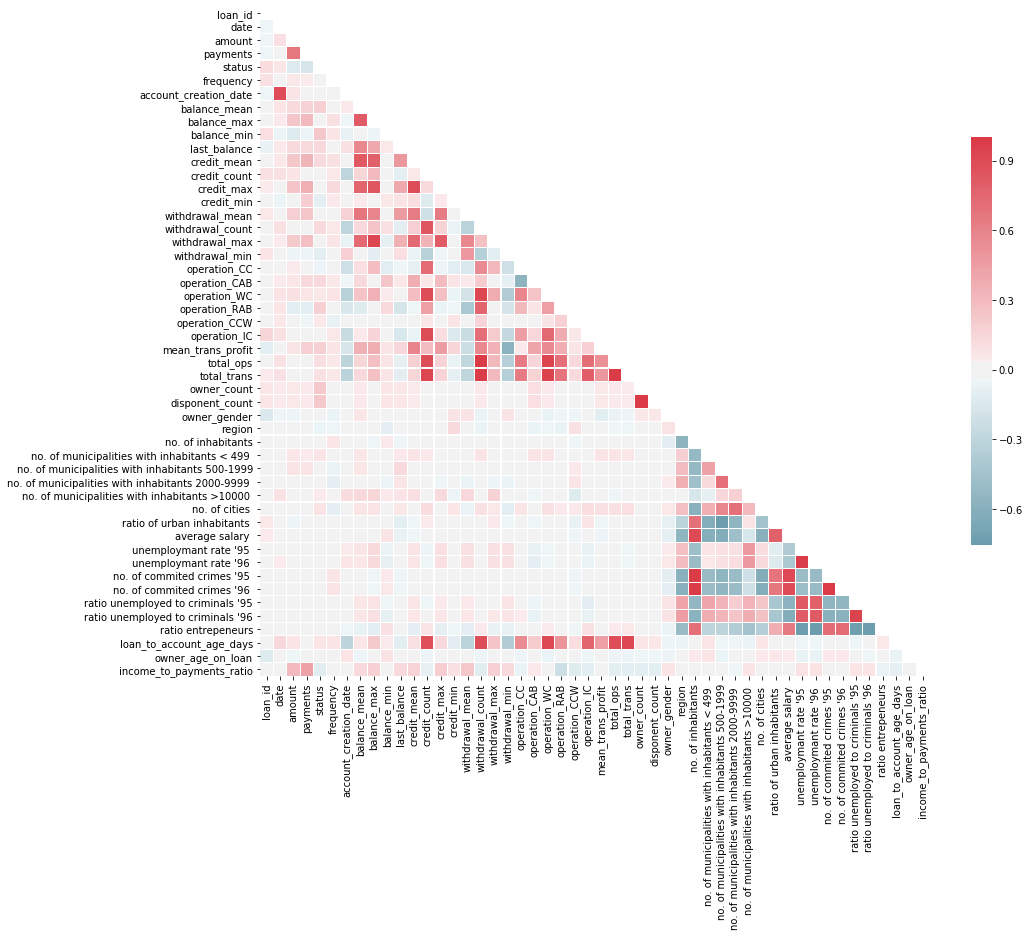

 >>> Final table that will serve as input to the model:


,amount,payments,frequency,balance_mean,balance_max,balance_min,last_balance,credit_mean,credit_count,credit_max,credit_min,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,operation_CC,operation_CAB,operation_WC,operation_RAB,operation_CCW,operation_IC,mean_trans_profit,total_trans,owner_count,owner_gender,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of commited crimes '95,no. of commited crimes '96,ratio unemployed to criminals '95,ratio unemployed to criminals '96,ratio entrepeneurs,loan_to_account_age_days,owner_age_on_loan,income_to_payments_ratio,status
0,96396,8033,2,12250.000000,20100.0,1100.0,20100.0,5025.000000,4,9900.0,1100.0,0.000000,0.0,0.0,0.0,4,0,0,0,0,0,5025.000000,4.0,1,1,7,94812,15,13,8,2,10,0.818,9650,3.38,3.67,2985.0,2804,107.358312,124.094165,0.100,105,0.685425,0.000000,-1
1,165960,4610,1,52083.859459,120512.8,700.0,52208.9,13523.158824,17,36574.0,2.9,8884.240000,20.0,54300.0,14.6,12,0,12,8,0,5,4638.918824,37.0,1,0,2,112709,48,20,7,3,10,0.735,8369,1.79,2.31,2854.0,2618,70.689947,99.449118,0.117,148,0.241205,-0.075325,1
2,127080,2118,1,30060.954167,49590.4,800.0,20272.8,5009.733333,15,19065.0,48.6,6097.000000,9.0,14800.0,66.0,2,5,6,3,0,8,-1087.266667,24.0,1,0,2,77917,85,19,6,1,5,0.535,8390,2.28,2.89,2080.0,2122,85.409019,106.116932,0.132,170,0.922457,-0.312244,1
3,105804,2939,1,41297.480000,65898.5,1000.0,34307.3,9254.600000,13,26448.0,132.8,7168.100000,12.0,15600.0,14.6,2,6,10,2,0,5,2086.500000,25.0,1,1,5,177686,69,27,10,1,9,0.748,10045,1.42,1.71,6604.0,6295,38.206257,48.267365,0.135,185,0.840626,-0.198310,1
4,274740,4579,2,57188.211111,122893.1,600.0,41112.9,21255.930769,13,63366.0,77.1,16801.000000,14.0,36700.0,30.0,1,6,11,3,0,6,4454.930769,27.0,1,0,6,86513,38,36,5,1,5,0.505,8288,3.79,4.52,1562.0,1460,209.913105,267.834767,0.110,204,0.030136,-0.013758,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,155616,3242,1,44197.509884,75294.1,200.0,60694.1,6448.582857,70,26388.0,23.7,3830.458824,102.0,36960.0,14.6,26,0,66,36,0,44,2618.124034,172.0,2,1,4,226122,32,50,7,4,4,0.626,8994,3.80,4.79,9672.0,9208,88.840323,117.628625,0.110,691,0.256158,-0.066497,1
324,222180,3703,1,55230.444068,130659.1,800.0,59578.8,13417.557143,28,44352.0,103.2,10197.180645,31.0,52600.0,14.6,16,0,31,0,0,12,3220.376498,59.0,1,0,7,45714,52,10,5,1,6,0.556,8843,2.82,3.60,818.0,888,157.595941,185.327027,0.113,382,0.934917,0.000000,-1
325,45024,938,1,41994.907692,63659.3,800.0,38384.3,8544.930000,20,31636.5,41.0,6974.431579,19.0,22100.0,14.6,8,0,13,6,0,12,1570.498421,39.0,1,1,4,285387,0,2,8,5,7,0.899,10177,6.63,7.75,9878.0,10108,191.548472,218.811758,0.081,214,0.551608,-0.419243,1
326,115812,3217,1,56646.516129,119527.2,1100.0,41878.1,16554.986275,51,49887.0,51.1,10992.139726,73.0,50800.0,14.6,32,0,73,0,0,19,5562.846548,124.0,1,0,5,93931,74,21,10,1,8,0.569,8427,1.12,1.54,1874.0,1913,56.138058,75.616174,0.107,585,0.634888,0.000000,1


 > And the respective correlations


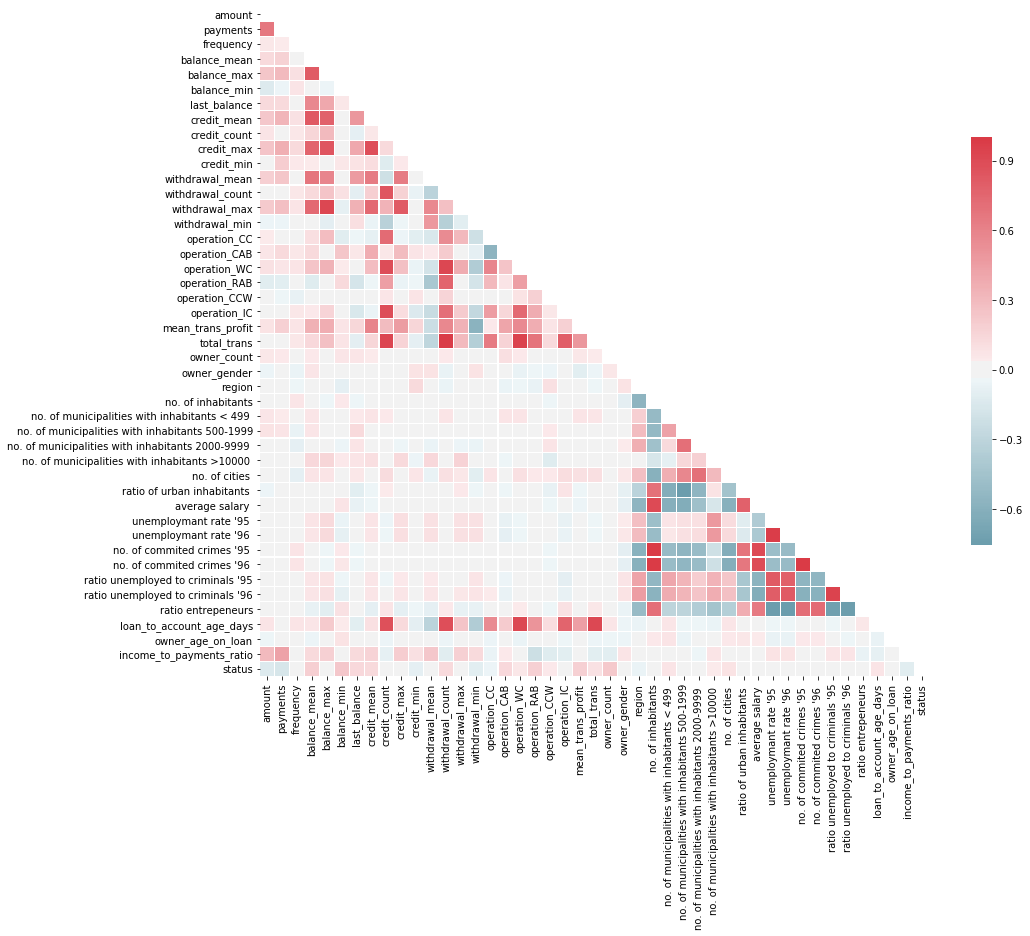

 > And the respective histograms for the given features


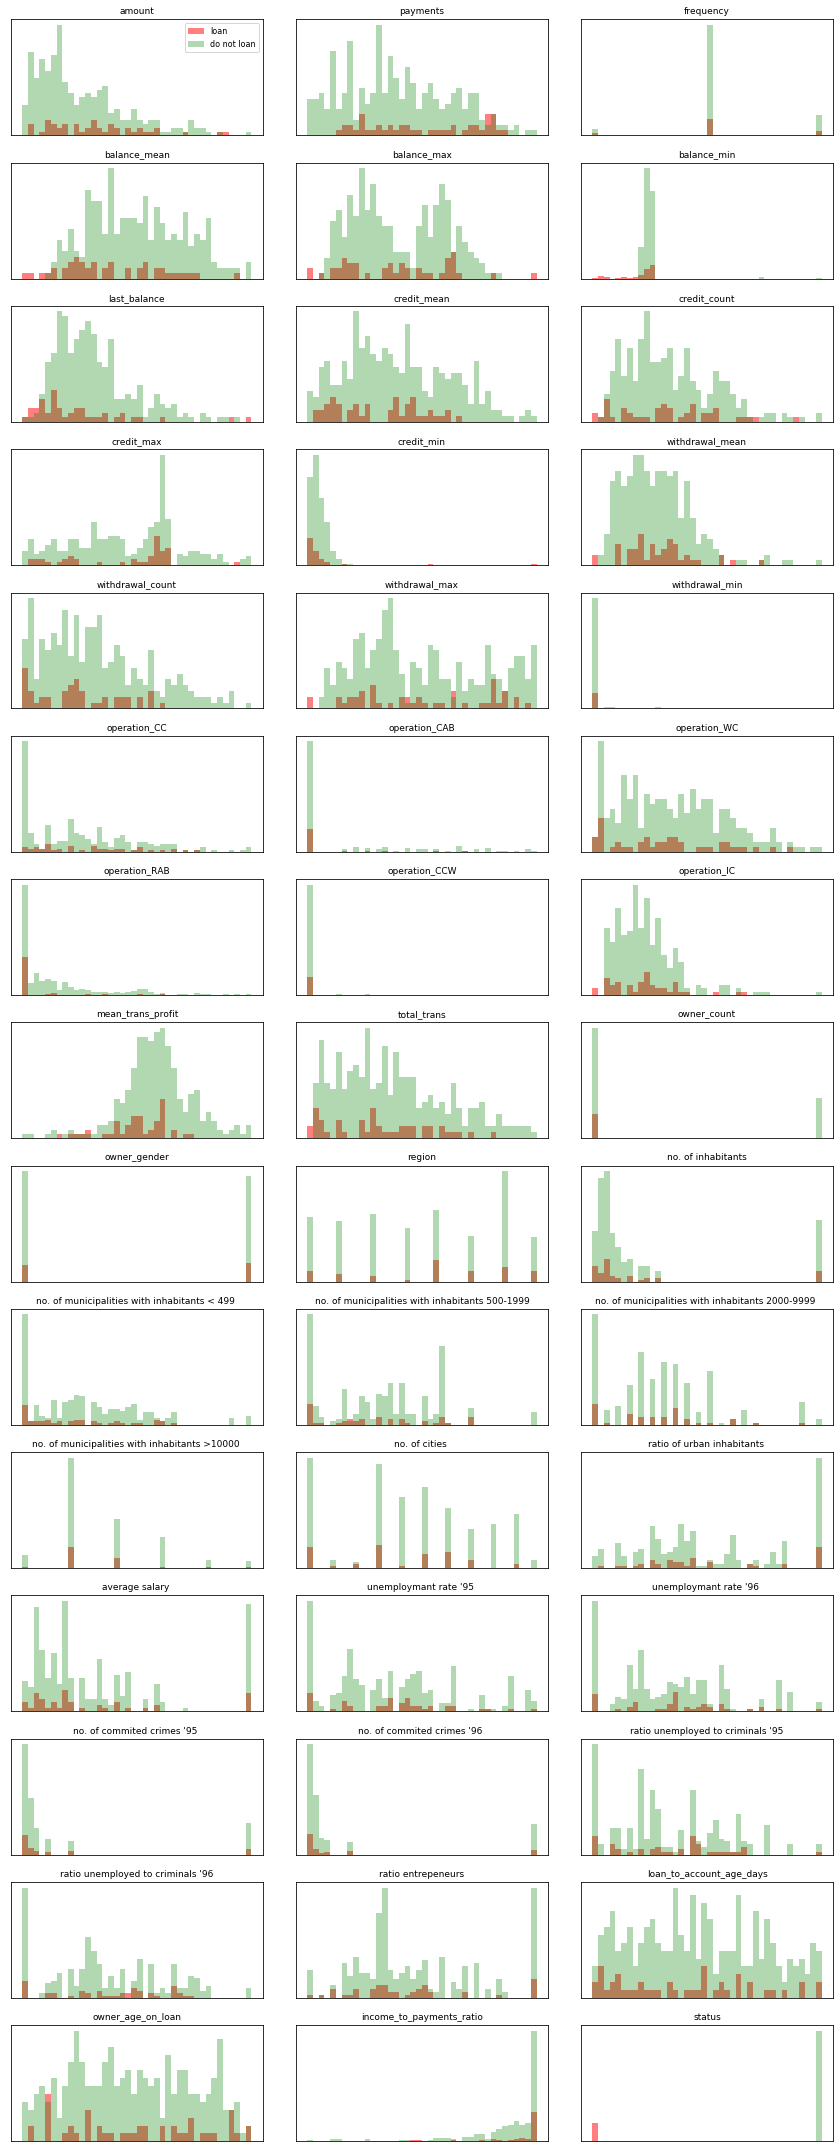

In [27]:
def compose_dataset(loan_df, account_df, disp_df, card_df, client_df, trans_df, demogra_df,
                    debug=False, pre_debug=False):
    '''Join the different tables and apply feature engineering'''

    # Pre processment of all the necessary tables
    processed_loan = process_loans(loan_df, pre_debug)
    processed_account = process_account(account_df, pre_debug)
    processed_trans = process_transactions(trans_df, pre_debug)
    processed_disp = process_dispostition(disp_df, pre_debug)
    processed_client = process_client(client_df, pre_debug)
    processed_card = process_card(card_df, pre_debug)
    processed_demogra = process_demographic(demogra_df, pre_debug)

    # Joining the different tables
    main_df = processed_loan.merge(processed_account.rename(columns={'date': 'account_creation_date'}),
                                   on='account_id', how='left')\
                            .merge(processed_trans.rename(columns={'date': 'trans_date'}),
                                   on='account_id', how='left')
    main_df = main_df.drop(['district_id'], axis=1)

    if debug:
        print(' > Joint table of loans, account, transaction:')
        display(main_df)
        
    ################################################

    df_disp_client_card = processed_disp.merge(processed_client,
                                              on='client_id', how='left')\
                                        .merge(processed_card,
                                              on='disp_id', how='left')
    if debug:
        print(' > Joint table of disposition, client & card:')
        display(df_disp_client_card)
        get_null_summary(df_disp_client_card)
    
    # Since there are so many, we disconsider the client columns
    df_disp_client = df_disp_client_card.drop(['issued', 'type_C', 'type_G', 'type_J'], axis=1)
    
    # Now we aggreggate the remaining data
    # TODO: not yet assure how to handle agg on birthdate and Gender -> using account and district id to get owner
    df_disp_client = df_disp_client.sort_values(by=['account_id', 'type_O'], ascending=[True, False])\
                                   .groupby(['account_id'])\
                                   .agg({
                                       'type_O': ['count'],
                                       'type_U': ['count'],
                                       'gender': get_first,
                                       'birth_date': get_first,
                                       'district_id': get_first
                                   })\
                                   .reset_index()
    df_disp_client.columns= ['account_id', 'owner_count', 'disponent_count',
                             'owner_gender', 'owner_birthdate', 'district_id']
    
    if debug:
        print(' > Table after aggreggating data by account_id:')
        display(df_disp_client)
        
    # Now we join the district information regarding the owner
    df_secondary = df_disp_client.merge(processed_demogra, on='district_id')
    
    if debug:
        print(' > Table after joining with the demographics table:')
        display(df_secondary)
    
    ################################################
    
    # Joining the previously built two major tables
    df = main_df.merge(df_secondary, on='account_id')
    
    # Creating new columns using previous ones
    df['loan_to_account_age_days'] = (df['date'] - df['account_creation_date']).dt.days
    df['owner_age_on_loan'] = (df['date'] - df['owner_birthdate']).dt.days
    df["date"] = pd.to_numeric(df["date"])
    df["account_creation_date"] = pd.to_numeric(df["account_creation_date"])
    # Average salary, pension and household are anual
    df['income_to_payments_ratio'] = ((df['average salary '] if df['pension'] is 0 else df['pension'])\
                                        - df['household'])/ 12 / df['payments']
    
    # Dropping useless columns & normalizing others
    df = df.drop(['district_id', 'account_id', 'owner_birthdate', 'duration', 'pension', 'household'], axis=1)
    normalize_columns(df, ['date', 'account_creation_date', 'owner_age_on_loan'])

    if debug:
        print(' > Obtained dataframe after joining the previous tables and doing some feature engineering over them')
        display(df)
        print(' > And the corresponding correlation matrix:')
        get_df_correlation(df, (15, 15))

    # Writing loan_id for later association on predictions
    utils.write_df_to_csv(df[['loan_id', 'amount', 'average salary ', 'last_balance']],
                          'dataset', 'ids.csv')
    df = df.drop(['loan_id', 'date', 'account_creation_date', 'total_ops', 'disponent_count'], axis=1)

    df =  df[[col for col in df if col not in ['status']] + ['status']]
    
    if debug: 
        print(' >>> Final table that will serve as input to the model:')
        display(df)
        print(' > And the respective correlations')
        get_df_correlation(df, (15, 15))
        print(' > And the respective histograms for the given features')
        get_features_histogram(df, (12, 30))
        
    return df

dataset = compose_dataset(loan_df, account_df, disp_df, card_df, client_df,
                          trans_df, demogra_df, debug=True, pre_debug=False)

In [28]:
# Outputting the resultant table to a final csv
utils.write_df_to_csv(dataset, 'dataset', 'preprocessed_data.csv')

test_dataset = compose_dataset(loan_test_df, account_df, disp_df,
                               card_test_df, client_df, trans_test_df, demogra_df)
utils.write_df_to_csv(test_dataset, 'dataset', 'test_dataset.csv')